# Использование HOG для классификации изображений

## Таблица результатов

**В данной таблице представлены экперименты на полном датасете изображений для моделей, которые лучше всего показали себя на ограниченной выборке**

|Модель|Гиперпараметры|Размер изображения|Цветное|HOG ориентация|HOG пикселей в клетке|HOG клеток в блоке|accuracy| accuracy на трейне|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|SVC|C=10, kernel='rbf'|64px|**да**|3|10,10|2,2|0.85|0.9722377232142857|
|SVC+PCA|C=10, kernel='rbf', n_components=0.6|64px|**да**|3|10,10|2,2|0.72|0.7865792410714286|
|SVC+PCA|C=10, kernel='rbf', n_components=0.4|64px|**да**|9|8,8|2,2|0.75|0.8213169642857143|
|SVC|C=10, kernel='rbf'|128px|**да**|3|12,12|10,10|0.89|0.9999441964285715|
|SVC+PCA|C=10, kernel='rbf', n_components=0.4|128px|**да**|3|12,12|10,10|0.60|0.6281529017857143|

**В данной таблице представлены экперименты на выборке по 500 изображений для каждого класса**

|Модель|Гиперпараметры|Размер изображения|Цветное|HOG ориентация|HOG пикселей в клетке|HOG клеток в блоке|accuracy| переобучение|
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|SVM|C=10, kernel='rbf'|64px|нет|9|8,8|2,2|**0.78**|-|
|SVM|C=10, kernel='rbf'|64px|**да**|9|8,8|2,2|**0.79**|-|
|SVM|C=5, kernel='rbf'|100px|нет|9|8,8|2,2|**0.78**|-|
|SVM|C=5, kernel='rbf'|128px|нет|9|8,8|2,2|**0.78**|-|
|SVM|C=5, kernel='rbf'|128px|нет|9|8,8|2,2|**0.78**|-|
|LogisticRegression + PCA|C=1|128px|нет|9|8,8|2,2|**0.59**|да|
|DecisionTree + PCA|min_samples_split=2, min_samples_leaf=1, max_depth=20, criterion='gini'|128px|нет|9|8,8|2,2|**0.49**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|9|8,8|2,2|**0.79**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|12|8,8|2,2|**0.7878125**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|6|8,8|2,2|**0.779375**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|9|6,6|2,2|**0.7815625**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|9|10,10|2,2|**0.78**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|нет|9|8,8|4,4|**0.7746875**|да|
|SVM|C=5, kernel='rbf'|128px|нет|3|12,12|10,10|**0.7853125**|да|
|SVM|C=20, kernel='rbf'|128px|нет|3|12,12|10,10|**0.785625**|полностью повторила трейн|
|SVM|C=10, kernel='rbf'|128px|**да**|3|12,12|10,10|**0.8028125**|да|
|SVM + PCA|C=5, kernel='rbf'|128px|**да**|9|8,8|2,2|**0.790625**|да|
|SVM|C=10, kernel='rbf'|128px|**да**|6|10,10|10,10|**0.7934375**|полностью повторила трейн|
|SVM|C=20, kernel='rbf'|64px|**да**|3|16,16|1,1|**0.5734375**|переобучена, но сильно меньше|
|SVM|C=5, kernel='rbf'|64px|**да**|3|10,10|2,2|**0.7646875**|переобучена, но сильно меньше|
|SVM|C=10, kernel='rbf'|64px|**да**|3|18,18|1,1|**0.4875**|переобучена, но сильно меньше|
|SVM|C=10, kernel='rbf'|64px|**да**|9|20,20|1,1|**0.6640625**|переобучена, но сильно меньше|


In [3]:
import zipfile
import os
import shutil
import random
import gdown

import cv2
from PIL import Image, ImageOps

from skimage.feature import hog

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm.auto import tqdm

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [5]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_DIR = os.path.join('/content/drive', 'MyDrive')
except ImportError:
    DRIVE_DIR = os.getcwd()

DATASET_DIR = os.path.join(os.getcwd(), 'dataset')
TEMP_DIR = os.path.join(os.getcwd(), 'temp')
ZIP_PATH = os.path.join(DRIVE_DIR,'dataset_32_classes.zip')
os.makedirs(DATASET_DIR, exist_ok=True)

Mounted at /content/drive


In [6]:
file_id = '1FKZ9oHZ3zFMoFJX2f2aI34M2XZ2ikSb0'
if os.path.exists(ZIP_PATH):
    print('Архив уже добавлен')
else:
    gdown.download(f'https://drive.google.com/uc?id={file_id}', os.path.join(os.getcwd(),'dataset_32_classes.zip'), quiet=False)

Архив уже добавлен


In [7]:
# Распаковка архива
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./dataset')

classes = os.listdir(DATASET_DIR)

# Проверим структуру папок
print(f'Количество папок: {len(classes)}')

Количество папок: 32


Данным методом буду изменять размеры изображений для сохранения пропорций.

set_image_size уменьшает/увеличивает изображение, сохраняя пропорции. Если у изображения останутся пустые области после ресайза, то их зальет белым цветом

In [8]:
def set_image_size(img_path:str, save_path:str, size:tuple[int, int]):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    ratio = img.width / img.height
    # Широкое изображение
    if ratio > 1:
        new_width = size[0]
        new_height = int(size[0] / ratio)
    # Высокое изображение
    else:
        new_height = size[1]
        new_width = int(size[1] * ratio)
    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    img_padded = ImageOps.pad(img_resized, size, color="white", centering=(0.5, 0.5))
    img_padded.save(save_path)

Датасет с измененным размером изображений буду хранить в отдельной temp-папке. Оригинальный датасет будет лежать в своей папке и не будет изменяться. Для экспериментов можно использовать ограниченный набор данных, поэтому в temp можно загрузить не весь измененный датасет, а только его часть

In [8]:
# Для тестовой выборки возьму 500 изображений из 1400. random всегда выдает разные значения, поэтому индексы запомню одни для всех экспериментов
random_indexes = random.sample([i for i in range(0, 1400)], 500)

In [9]:
def create_resized_dataset(size:tuple[int, int], random_indexes: list[int]|None):
    # Если папка уже была, то удалить из нее прошлое содержимое
    if os.path.exists(TEMP_DIR):
        shutil.rmtree(TEMP_DIR)
    os.mkdir(TEMP_DIR)

    for cl in tqdm(classes):

        temp_cl_path = os.path.join(TEMP_DIR, cl)
        if os.path.exists(temp_cl_path) == False:
            os.mkdir(temp_cl_path)

        folder_path = os.path.join(DATASET_DIR, cl)
        image_names = os.listdir(folder_path)
        if random_indexes is not None:
            image_names = [image_names[i] for i in random_indexes]
        for img_name in image_names:
            img_path = os.path.join(DATASET_DIR, cl, img_name)
            save_path = os.path.join(TEMP_DIR, cl, img_name)
            set_image_size(img_path, save_path, size)

In [ ]:
create_resized_dataset((64, 64), random_indexes)

  0%|          | 0/32 [00:00<?, ?it/s]

## Взиуализация гистограммы направленных градиентов

Визуализируем HOG

In [10]:
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html#sphx-glr-auto-examples-features-detection-plot-hog-py
def show_hog_image(img_path):

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # orientations: Больше ориентаций (например, 9-18) дают более точные градиенты.
    # pixels_per_cell: Меньшие размеры ячеек (например, 4×4) захватывают больше деталей, но увеличивают размер признаков.
    # cells_per_block: Увеличивает устойчивость к изменению яркости.
    features, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )

    plt.figure(figsize=(4, 2))

    plt.subplot(1, 3, 1)
    plt.title("Изображение")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("HOG визуализация")
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


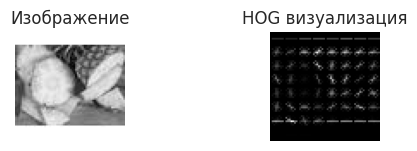

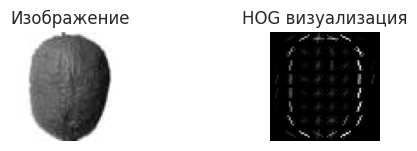

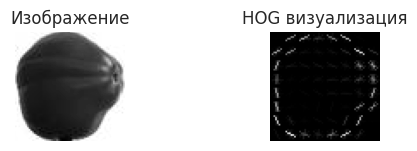

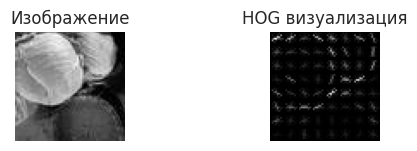

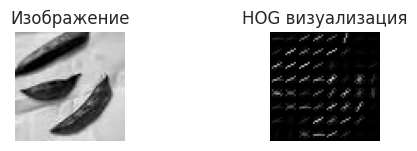

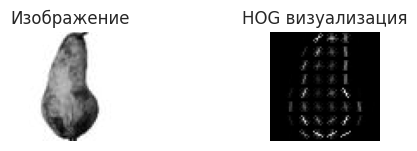

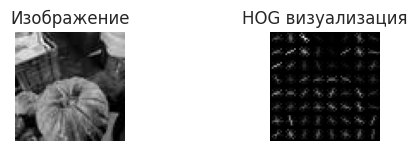

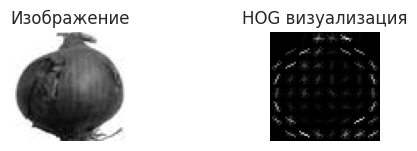

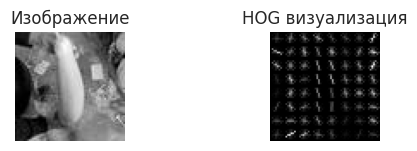

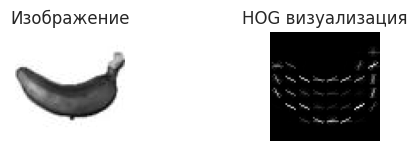

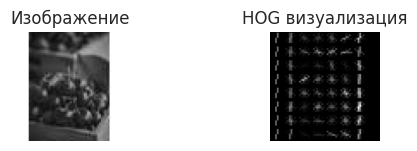

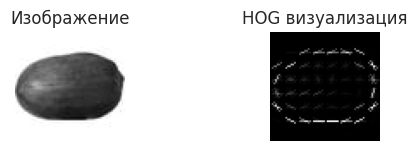

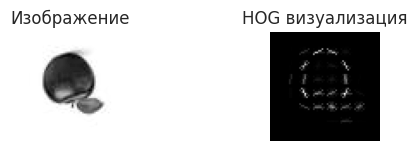

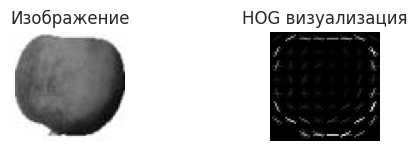

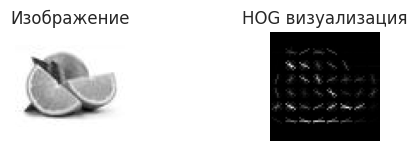

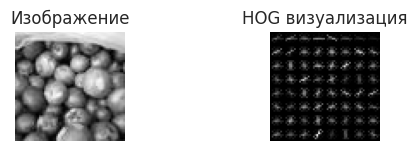

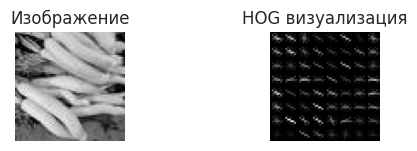

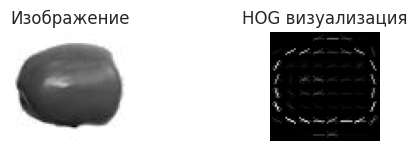

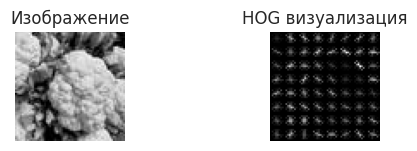

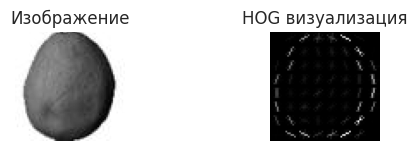

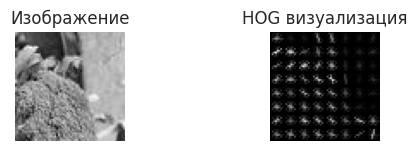

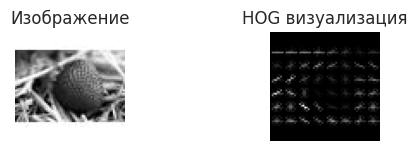

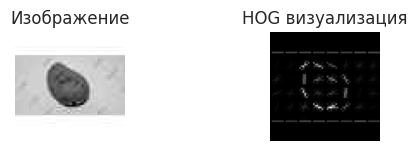

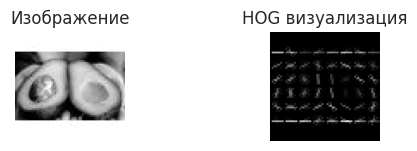

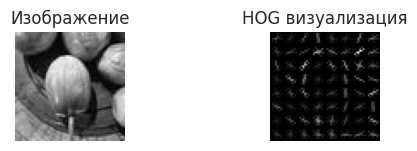

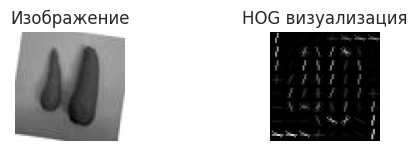

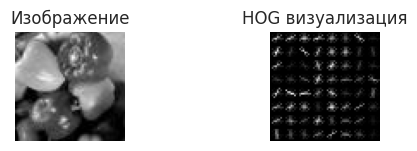

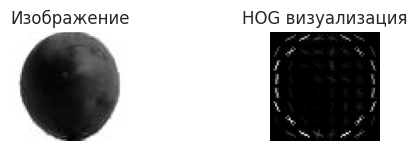

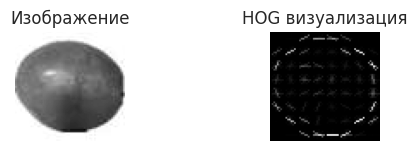

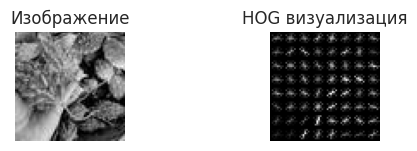

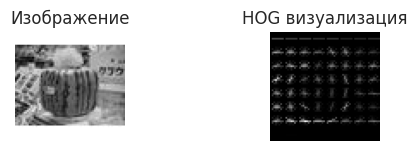

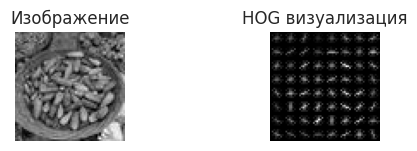

In [ ]:
for cl in classes:
    folder_path = os.path.join(TEMP_DIR, cl)
    img_name = random.sample(os.listdir(folder_path), 1)[0]
    img_path = os.path.join(TEMP_DIR, cl, img_name)
    show_hog_image(img_path)

## Проверка модели на черно-белых изображениях

Сперва проверим SVM модель на черно белых изображениях с размером 64*64px

In [11]:
# Загрузка чб партинок
def load_images_and_labels(dataset_path: str):
    images = []
    labels = []
    classes = os.listdir(dataset_path)
    for class_label in tqdm(classes):
        class_folder = os.path.join(dataset_path, class_label)
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(img)
            labels.append(class_label)
    return np.array(images), np.array(labels)

# Выделение HOG значений из изображений
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for img in tqdm(images):
        features = hog(img, orientations, pixels_per_cell, cells_per_block, block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

Стоит определить какие гиперпараметры использовать для SVM, подберу C и kernel

In [ ]:
print("Загрузка изображений...")
images, labels = load_images_and_labels(TEMP_DIR)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_STATE)

print("Выделение HOG значений...")
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print("Обучение модели...")
param_grid = {'C': [1, 5, 10, 50], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svс_gray64 = GridSearchCV(SVC(), param_grid)
svс_gray64.fit(X_train_hog, y_train)
y_pred = svс_gray64.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

Обучение модели...


In [ ]:
svс_gray64.best_params_, svс_gray64.best_score_

({'C': 10, 'kernel': 'rbf'}, 0.74703125)

Лучше всего для решаемой задачи подошли гиперпараметры **C=10, kernel='rbf'**. Далее можно будет отталкиваться от них

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.62      0.63      0.63       108
     Avocado       0.70      0.67      0.68        94
      Banana       0.69      0.66      0.68       103
        Bean       0.69      0.77      0.73       110
Bitter_Gourd       0.65      0.82      0.73        90
Bottle_Gourd       0.86      0.91      0.88       111
     Brinjal       0.66      0.66      0.66        92
    Broccoli       0.64      0.62      0.63       110
     Cabbage       0.56      0.72      0.63        85
    Capsicum       0.69      0.80      0.74        90
      Carrot       0.72      0.76      0.74       100
 Cauliflower       0.79      0.68      0.73       103
      Cherry       0.72      0.65      0.68        99
    Cucumber       0.86      0.86      0.86        97
       Grape       0.97      1.00      0.98        84
        Kiwi       0.60      0.66      0.63        83
       Mango       0.69      0.65      0.67       102
         Nut       0.99    

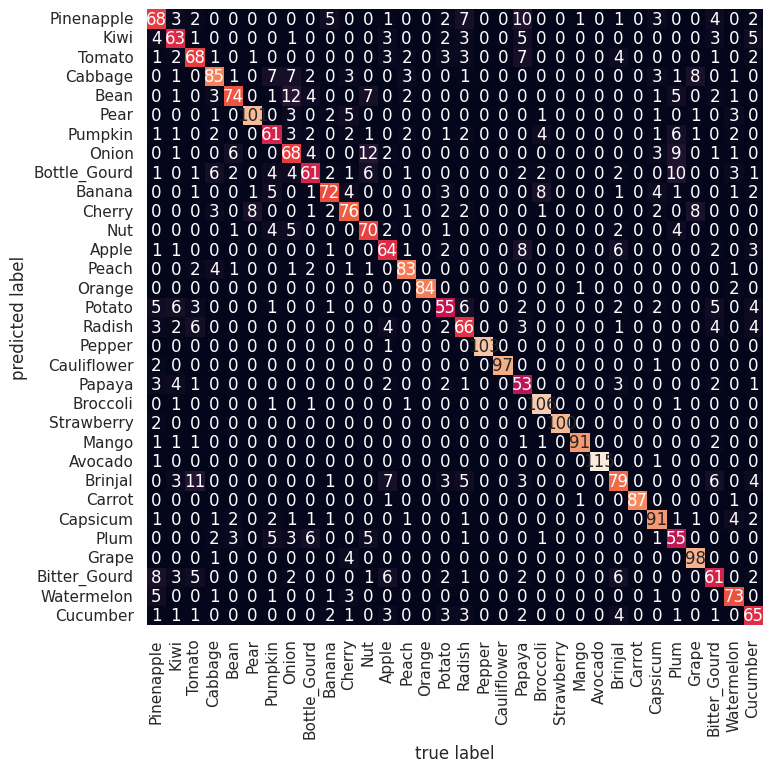

In [ ]:
# https://github.com/Murcha1990/ML_AI24/blob/main/Lesson11_SVM_Calibration/ML_AI_SVM.ipynb
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

**По матрице ошибок видно, что, в целом, модель угадывает классы.**

## Проверка модели на цветных изображениях

In [12]:
def load_colored_images_and_labels(dataset_path: str):
    images = []
    labels = []
    classes = os.listdir(dataset_path)
    for class_label in tqdm(classes):
        class_folder = os.path.join(dataset_path, class_label)
        for file in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB
            images.append(img)
            labels.append(class_label)
    return np.array(images), np.array(labels)


def extract_hog_color_features(images, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for image in tqdm(images):
        img_hog_features = []
        for channel in cv2.split(image):
            features = hog(
                channel,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=False
            )
            img_hog_features.append(features)
        hog_features.append(np.hstack(img_hog_features))
    return np.array(hog_features)

У цветных изображений попробую подобрать другой гиперпараметр C

In [16]:
# Далее буду обучать с 2 фолдами, т.к. обучение занимает очень много времени
kfold = KFold(2, shuffle=True)

In [ ]:
print("Загрузка изображений...")
images, labels = load_colored_images_and_labels(TEMP_DIR)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_STATE)

print("Выделение HOG значений...")
X_train_hog = extract_hog_color_features(X_train)
X_test_hog = extract_hog_color_features(X_test)

print("Обучение модели...")
param_grid = {'C': [1, 5, 10, 50], 'kernel':['rbf']}
svс_colored64 = GridSearchCV(SVC(), param_grid, cv=kfold)
svс_colored64.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = svс_colored64.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

Обучение модели...
Получение предсказаний модели...


In [ ]:
svс_colored64.best_params_, svс_colored64.best_score_

({'C': 10, 'kernel': 'rbf'}, 0.714140625)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.72      0.66      0.69       108
     Avocado       0.68      0.69      0.69        94
      Banana       0.69      0.64      0.67       103
        Bean       0.70      0.75      0.73       110
Bitter_Gourd       0.68      0.87      0.76        90
Bottle_Gourd       0.86      0.89      0.88       111
     Brinjal       0.64      0.67      0.66        92
    Broccoli       0.67      0.65      0.66       110
     Cabbage       0.58      0.74      0.65        85
    Capsicum       0.69      0.80      0.74        90
      Carrot       0.75      0.78      0.76       100
 Cauliflower       0.73      0.66      0.69       103
      Cherry       0.74      0.67      0.70        99
    Cucumber       0.89      0.88      0.88        97
       Grape       1.00      1.00      1.00        84
        Kiwi       0.63      0.69      0.66        83
       Mango       0.68      0.68      0.68       102
         Nut       0.99    

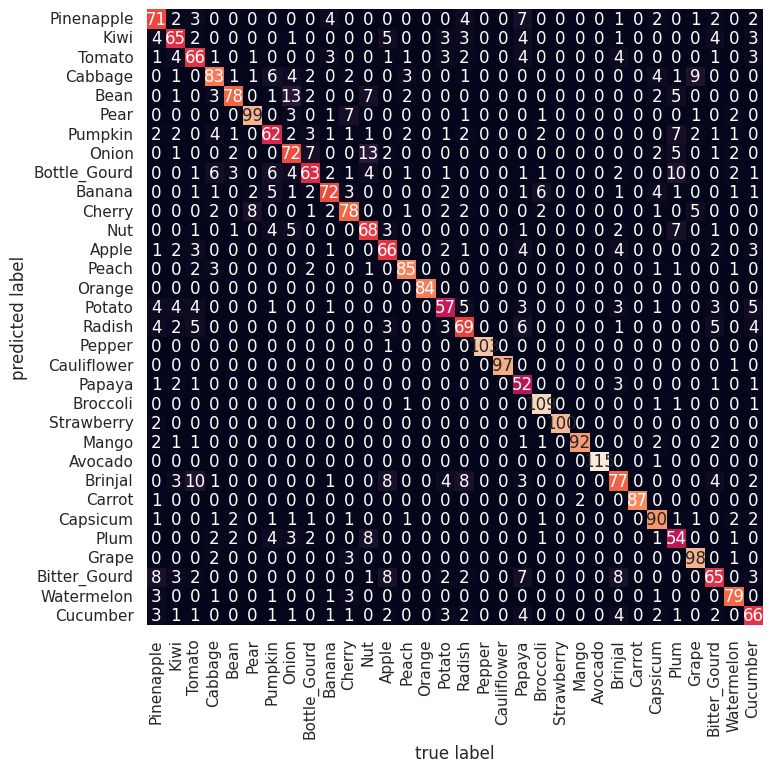

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

Обученная на HOG от цветных изображений модель стала предсказывать незначительно лучше.

Результаты отличаются незначительно, поэтому можно дальнейшие проверки проводить на черно-белых изображениях для уменьшения затрат ресурсов.

## Проверка влияния размера изображений на качество предсказаний моделью

Следует изучить различие в качестве предсказаний для моделей, обученных на изображениях разного размера.

В EDA было принято решение проверить модель на изображениях размером 64x64, 100x100 128x128, 192x192. Для изображений размером 224x224px будет очень много признаков, SVM модель будет обучаться очень долго, поэтому эти изображения рассматриваться не будут

У больших изображений будет больше признаков, поэтому стоит поискать новый гиперпараметр C.

Изображения 64x64 были рассмотренны ранее, обучим модель на изображениях 100x100

### Изображения 100*100px

In [13]:
def upload_hog_features(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    print("Загрузка изображений...")
    images, labels = load_images_and_labels(TEMP_DIR)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_STATE)

    print("Выделение HOG значений...")
    X_train_hog = extract_hog_features(X_train, orientations, pixels_per_cell, cells_per_block)
    X_test_hog = extract_hog_features(X_test, orientations, pixels_per_cell, cells_per_block)

    return X_train_hog, X_test_hog, y_train, y_test

In [14]:
def upload_colored_hog_features(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    print("Загрузка изображений...")
    images, labels = load_colored_images_and_labels(TEMP_DIR)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=RANDOM_STATE)

    print("Выделение HOG значений...")
    X_train_hog = extract_hog_color_features(X_train, orientations, pixels_per_cell, cells_per_block)
    X_test_hog = extract_hog_color_features(X_test, orientations, pixels_per_cell, cells_per_block)

    return X_train_hog, X_test_hog, y_train, y_test

In [ ]:
create_resized_dataset((100, 100), random_indexes)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features()

print("Обучение модели...")
param_grid = {'C': [1, 5, 10, 50], 'kernel':['rbf']}
svс_gray100 = GridSearchCV(SVC(), param_grid, cv=kfold)
svс_gray100.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = svс_gray100.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

Обучение модели...
Получение предсказаний модели...


In [ ]:
svс_gray100.best_params_, svс_gray100.best_score_

({'C': 5, 'kernel': 'rbf'}, 0.70203125)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.66      0.66      0.66       108
     Avocado       0.62      0.67      0.65        94
      Banana       0.67      0.67      0.67       103
        Bean       0.69      0.75      0.72       110
Bitter_Gourd       0.64      0.80      0.71        90
Bottle_Gourd       0.81      0.86      0.83       111
     Brinjal       0.68      0.68      0.68        92
    Broccoli       0.70      0.69      0.69       110
     Cabbage       0.53      0.72      0.61        85
    Capsicum       0.70      0.73      0.72        90
      Carrot       0.70      0.76      0.73       100
 Cauliflower       0.80      0.72      0.76       103
      Cherry       0.80      0.68      0.73        99
    Cucumber       0.88      0.87      0.88        97
       Grape       0.97      1.00      0.98        84
        Kiwi       0.70      0.64      0.67        83
       Mango       0.68      0.65      0.66       102
         Nut       0.98    

### Изображения 128*128px

In [ ]:
create_resized_dataset((128, 128), random_indexes)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features()

print("Обучение модели...")
param_grid = {'C': [1, 5, 10], 'kernel':['rbf', 'linear']}
svс_gray128 = GridSearchCV(SVC(), param_grid, cv=kfold)
svс_gray128.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = svс_gray128.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

Обучение модели...
Получение предсказаний модели...


In [ ]:
svс_gray128.best_params_, svс_gray128.best_score_

({'C': 5, 'kernel': 'rbf'}, 0.7008593750000001)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.63      0.66      0.65       108
     Avocado       0.62      0.65      0.64        94
      Banana       0.78      0.68      0.73       103
        Bean       0.71      0.72      0.71       110
Bitter_Gourd       0.63      0.86      0.72        90
Bottle_Gourd       0.82      0.86      0.84       111
     Brinjal       0.66      0.70      0.68        92
    Broccoli       0.80      0.77      0.79       110
     Cabbage       0.54      0.79      0.64        85
    Capsicum       0.76      0.82      0.79        90
      Carrot       0.73      0.75      0.74       100
 Cauliflower       0.81      0.65      0.72       103
      Cherry       0.71      0.64      0.67        99
    Cucumber       0.87      0.87      0.87        97
       Grape       0.97      1.00      0.98        84
        Kiwi       0.70      0.59      0.64        83
       Mango       0.67      0.67      0.67       102
         Nut       0.99    

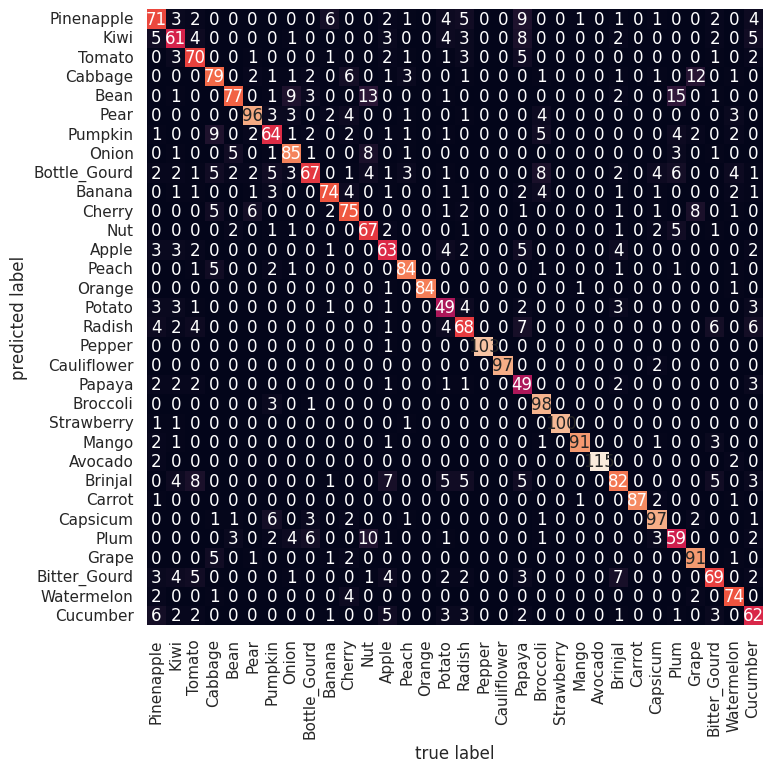

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

**Модель не сильно улучшается от изменения размера изображений.**

## Проверка других моделей

Стоит проверить другие модели - логистической регрессии и деревья решений. Возможно, они покажут лучший результат. Так же SVM долго обучается, поэтому для дальнейших экспериментов можно будет использовать другую модель, а контроль произвести на SVM

In [ ]:
create_resized_dataset((128, 128), random_indexes)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features()

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [16]:
pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=RANDOM_STATE)

Для сравнения обучим svm на уменьшенных признаках

In [ ]:
svc = SVC(C=5, kernel='rbf')
model_svc = make_pipeline(pca, svc)

In [ ]:
print("Обучение модели...")
model_svc.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = model_svc.predict(X_test_hog)

Обучение модели...
Получение предсказаний модели...


In [ ]:
y_pred_tr = model_svc.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9996875

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.59      0.59      0.59        93
     Avocado       0.64      0.72      0.68       100
      Banana       0.68      0.71      0.69       115
        Bean       0.67      0.73      0.70        94
Bitter_Gourd       0.75      0.92      0.83       103
Bottle_Gourd       0.91      0.92      0.91       110
     Brinjal       0.81      0.69      0.75       111
    Broccoli       0.69      0.82      0.75        90
     Cabbage       0.57      0.70      0.63        92
    Capsicum       0.76      0.76      0.76       124
      Carrot       0.86      0.75      0.80       117
 Cauliflower       0.64      0.79      0.71        85
      Cherry       0.62      0.65      0.63        94
    Cucumber       0.87      0.83      0.85       108
       Grape       0.99      0.98      0.99       110
        Kiwi       0.77      0.65      0.70        97
       Mango       0.71      0.69      0.70        97
         Nut       0.99    

### Проверка модели логистической регрессии

In [ ]:
lr = LogisticRegression()
model_lr = make_pipeline(pca, lr)

In [ ]:
print("Обучение модели...")
param_grid = {'logisticregression__C': [0.01, 0.1, 1]}
logreg_gray128 = GridSearchCV(model_lr, param_grid, cv=kfold)
logreg_gray128.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = logreg_gray128.predict(X_test_hog)

Обучение модели...
Получение предсказаний модели...


In [ ]:
y_pred_tr = logreg_gray128.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.682109375

In [ ]:
logreg_gray128.best_params_, logreg_gray128.best_score_

({'logisticregression__C': 1}, 0.54609375)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.38      0.28      0.32       108
     Avocado       0.44      0.47      0.46        94
      Banana       0.48      0.47      0.48       103
        Bean       0.49      0.55      0.52       110
Bitter_Gourd       0.50      0.72      0.59        90
Bottle_Gourd       0.67      0.68      0.67       111
     Brinjal       0.43      0.46      0.44        92
    Broccoli       0.64      0.54      0.58       110
     Cabbage       0.40      0.36      0.38        85
    Capsicum       0.41      0.40      0.40        90
      Carrot       0.43      0.45      0.44       100
 Cauliflower       0.56      0.60      0.58       103
      Cherry       0.43      0.35      0.39        99
    Cucumber       0.51      0.54      0.52        97
       Grape       0.90      0.99      0.94        84
        Kiwi       0.47      0.42      0.45        83
       Mango       0.40      0.42      0.41       102
         Nut       0.95    

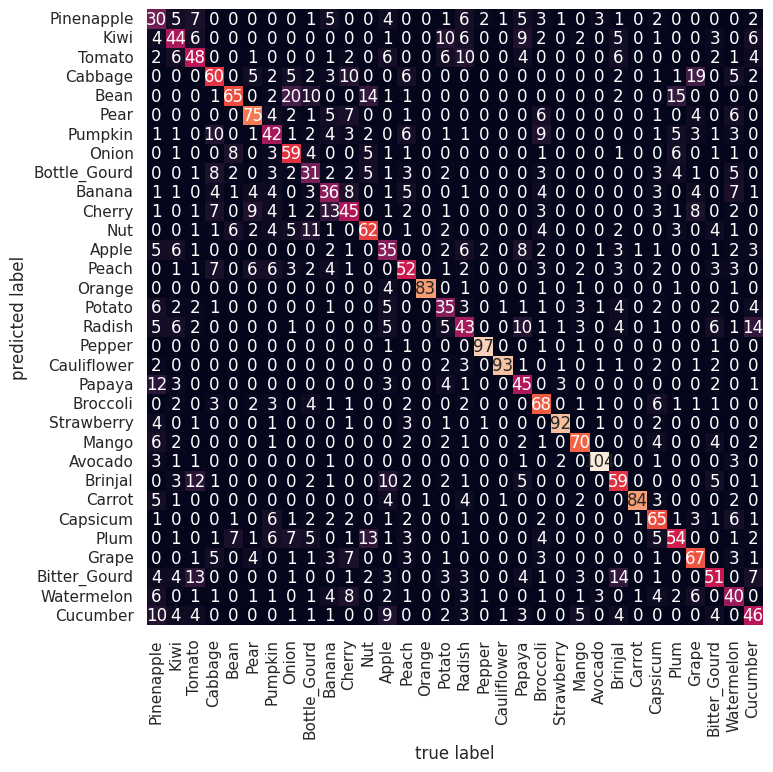

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

**ВЫВОД**: Модель логистической регрессии хуже справляется с текущей задачей. Также модель сильно переобучается (accuracy = 0.67, accuracy = 0.59 )

### Проверка модели решающих деревьев

In [ ]:
dec_tree = DecisionTreeClassifier()
model_dt = make_pipeline(pca, dec_tree)

In [ ]:
print("Обучение модели...")
param_grid = {
    'decisiontreeclassifier__max_depth': [5, 10, 20, 30],
    'decisiontreeclassifier__min_samples_split': [2, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [1, 5, 10],
    'decisiontreeclassifier__max_features': [None, 'sqrt', 'log2'],
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}
tree_gray128 = RandomizedSearchCV(model_dt, param_grid, cv=kfold, n_iter=10)
tree_gray128.fit(X_train_hog, y_train)
print("Получение предсказаний модели...")
y_pred = tree_gray128.predict(X_test_hog)

Обучение модели...
Получение предсказаний модели...


In [ ]:
y_pred_tr = tree_gray128.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.874296875

In [ ]:
tree_gray128.best_params_, tree_gray128.best_score_

({'decisiontreeclassifier__min_samples_split': 2,
  'decisiontreeclassifier__min_samples_leaf': 1,
  'decisiontreeclassifier__max_features': None,
  'decisiontreeclassifier__max_depth': 20,
  'decisiontreeclassifier__criterion': 'gini'},
 0.42796875)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.21      0.24      0.22        93
     Avocado       0.37      0.48      0.42       100
      Banana       0.39      0.38      0.39       115
        Bean       0.33      0.32      0.32        94
Bitter_Gourd       0.59      0.69      0.63       103
Bottle_Gourd       0.53      0.55      0.54       110
     Brinjal       0.40      0.34      0.37       111
    Broccoli       0.43      0.54      0.48        90
     Cabbage       0.25      0.24      0.24        92
    Capsicum       0.52      0.40      0.45       124
      Carrot       0.51      0.45      0.48       117
 Cauliflower       0.51      0.56      0.54        85
      Cherry       0.27      0.41      0.33        94
    Cucumber       0.49      0.51      0.50       108
       Grape       0.83      0.75      0.78       110
        Kiwi       0.40      0.44      0.42        97
       Mango       0.48      0.47      0.48        97
         Nut       0.77    

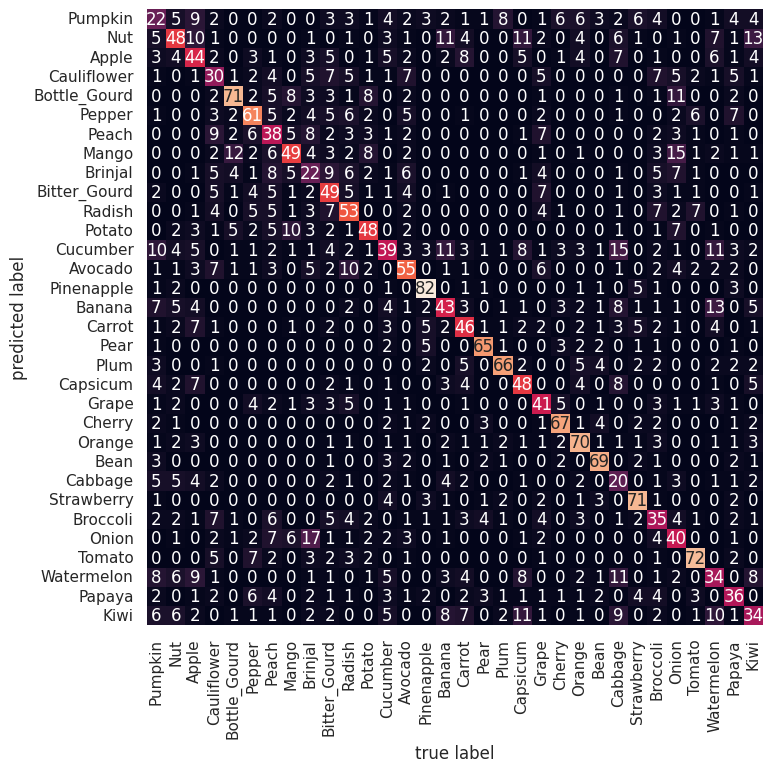

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

**ВЫВОД**: Модель решающих деревьев хуже справляется с текущей задачей. Также модель сильно переобучается (accuracy = 0.87, accuracy = 0.49 ) и часто ошибается.

## Гиперпараметры HOG

**Модели сильно переобучаются, стоит подобрать оптимальные гиперпараметры HOG.**

Попробуем улучшить качество предсказаний модели с помощью подбора гиперпараметров HOG
- orientations: Больше ориентаций (например, 9-18) дают более точные градиенты.
- pixels_per_cell: Меньшие размеры ячеек (например, 4×4) захватывают больше деталей, но увеличивают размер признаков.
- cells_per_block: Увеличивает устойчивость к изменению яркости.

In [15]:
def show_hog_diffs(images):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 5, 1)
    plt.title("Изображение")
    plt.imshow(images[0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.title("HOG визуализация")
    plt.imshow(images[1], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("HOG визуализация")
    plt.imshow(images[2], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Визуализация разницы гиперпараметров приведена ниже на примере изображения ананаса

orientations 15, 9, 3


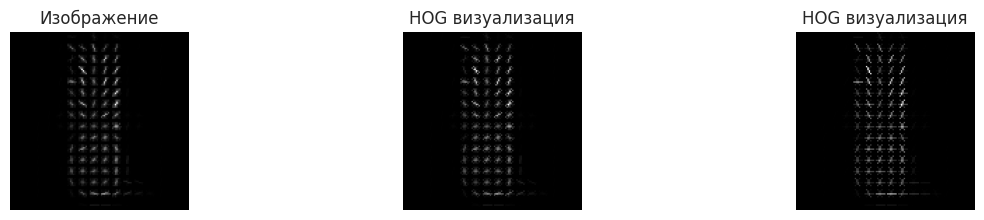

pixels_per_cell (4, 4), (8, 8), (12, 12)


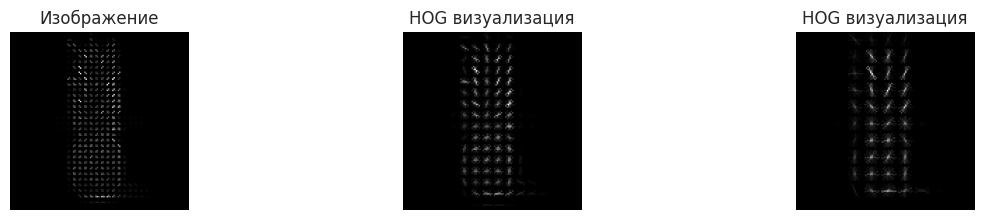

cells_per_block (2, 2), (6, 6), (10, 10)


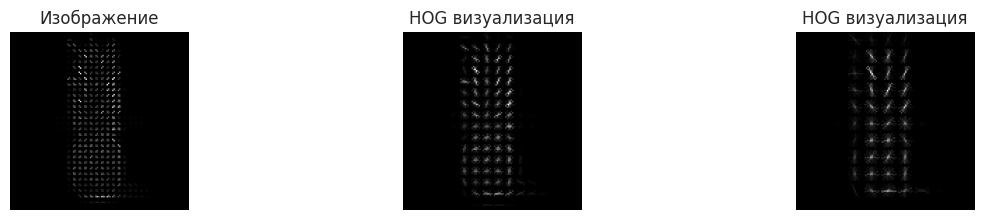

итог по каждому шагу


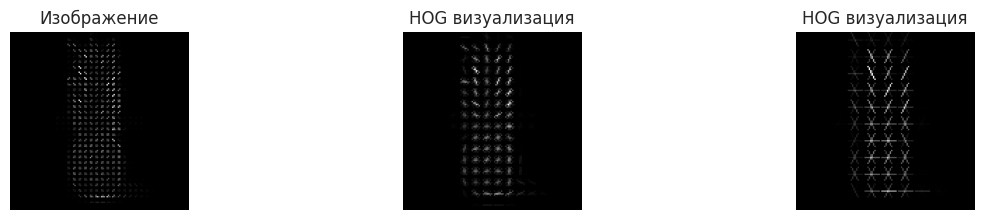

In [ ]:
image = cv2.imread('/content/temp/Pinenapple/img_31_ (26).jpeg', cv2.IMREAD_GRAYSCALE)

features, hog_image_o1 = hog(image, orientations=15, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_o2 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_o3 = hog(image, orientations=3, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

features, hog_image_p1 = hog(image, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_p2 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_p3 = hog(image, orientations=9, pixels_per_cell=(12, 12), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)

features, hog_image_c1 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_c2 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(6, 6), block_norm='L2-Hys', visualize=True)
features, hog_image_c3 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(10, 10), block_norm='L2-Hys', visualize=True)

features, hog_image_ex1 = hog(image, orientations=15, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
features, hog_image_ex2 = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(6, 6), block_norm='L2-Hys', visualize=True)
features, hog_image_ex3 = hog(image, orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10), block_norm='L2-Hys', visualize=True)

print("orientations 15, 9, 3")
show_hog_diffs([hog_image_o1, hog_image_o2, hog_image_o3])
print("pixels_per_cell (4, 4), (8, 8), (12, 12)")
show_hog_diffs([hog_image_p1, hog_image_p2, hog_image_p3])
print("cells_per_block (2, 2), (6, 6), (10, 10)")
show_hog_diffs([hog_image_p1, hog_image_p2, hog_image_p3])
print("итог по каждому шагу")
show_hog_diffs([hog_image_ex1, hog_image_ex2, hog_image_ex3])

Стоит попробовать поизмеять orientations, pixels_per_cell и cells_per_block, чтобы найти оптимальные значения.

Сильное изменения pixels_per_cell и cells_per_block, возможно, и поможет улучшить качество модели, но многократно увеличит количество признаков. Также уменьшение этих гиперпараметров может привести к еще большему переобучению.

In [ ]:
svc = SVC(C=5, kernel='rbf')
svc_model = make_pipeline(pca, svc)

Для orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)  
- на трейне: 0.9996875  
- на тесте 0.79

### Проверка orientation

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(orientations=12)

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.7878125

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9996875

Вероятно, увеличение значения orientations не дает результата

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(orientations=6)

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.779375

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.998671875

### Проверка pixels_per_cell

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(pixels_per_cell=(6, 6))

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.7815625

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.999375

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(pixels_per_cell=(10, 10))

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.78

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9996875

### Проверка cells_per_block

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(cells_per_block=(4, 4))

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.7746875

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9996875

### Подбор гиперпараметров HOG

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_hog_features(orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10))

param_grid = {'C':[5, 10, 20, 50, 100], 'kernel':['rbf']}
svc_model = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
svc_model.best_params_, svc_model.best_score_

({'C': 20, 'kernel': 'rbf'}, 0.703203125)

In [ ]:
accuracy_score(y_test, y_pred)

0.785625

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

1.0

На малом количестве признаков модель запомнила трейн. Стоит проверить эти же параметры для цветных изображений...

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10))

param_grid = {'C':[5, 10, 20, 50, 100], 'kernel':['rbf']}
svc_model = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
svc_model.best_params_, svc_model.best_score_

({'C': 10, 'kernel': 'rbf'}, 0.724140625)

In [ ]:
accuracy_score(y_test, y_pred)

0.8028125

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.999921875

На цветных значениях модель показывает результаты лучше. Далее стоит сравнивать HOG на цветных изображениях

Ранее не проверялось как сильно переобучается модель с цветными изображениями, проверю сейчас...

In [ ]:
svc = SVC(C=5, kernel='rbf')
svc_model = make_pipeline(pca, svc)

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features()

svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.790625

In [ ]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9996875

на цветных изображениях тоже переобучение

orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10) на цветных изображениях хорошо показали себя. Стоит попробовать похожие значения, которые дадут чуть больше признаков...

In [ ]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=6, pixels_per_cell=(10, 10), cells_per_block=(10, 10))

color_svc = SVC(kernel='rbf', C=10)
color_svc.fit(X_train_hog, y_train)
y_pred = color_svc.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [ ]:
accuracy_score(y_test, y_pred)

0.7934375

In [ ]:
y_pred_tr = color_svc.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

1.0

Стоит попробовать уменьшить признаки с помощью уменьшения размера изображения, уменьшения orientation, cells_per_block, увеличения pixells_per_cell

In [18]:
create_resized_dataset((64, 64), random_indexes)

  0%|          | 0/32 [00:00<?, ?it/s]

In [19]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=3, pixels_per_cell=(10, 10), cells_per_block=(2, 2))

svc_model = SVC(C=5, kernel='rbf')
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [20]:
accuracy_score(y_test, y_pred)

0.7646875

In [21]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.968515625

Стоит сильнее уменьшить признаки + подобрать гиперпараметры для SVM

In [29]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=3, pixels_per_cell=(16, 16), cells_per_block=(1, 1))


param_grid = {'C':[5, 10, 20, 50, 100], 'kernel':['rbf']}
svc_model = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [30]:
svc_model.best_params_

{'C': 20, 'kernel': 'rbf'}

In [31]:
accuracy_score(y_test, y_pred)

0.5734375

In [32]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.79

In [86]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=9, pixels_per_cell=(20, 20), cells_per_block=(1, 1))


svc_model = SVC(C=10, kernel='rbf')
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/12800 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

In [88]:
accuracy_score(y_test, y_pred)

0.6640625

In [89]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.901015625

Визуализируем 3 лучших подбора гиперпараметров HOG

## Проверка лучших подборов гиперпараметров на целом датасете

Сперва проверю **SVM	C=10, kernel='rbf'	64px	на цветных изображениях	orientations=3, pixels_per_cell=(10, 10), cells_per_block=(2, 2)**

In [17]:
create_resized_dataset((64, 64), None)

  0%|          | 0/32 [00:00<?, ?it/s]

In [109]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=3, pixels_per_cell=(10, 10), cells_per_block=(2, 2))

svc_model = SVC(C=5, kernel='rbf')
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/35840 [00:00<?, ?it/s]

  0%|          | 0/8960 [00:00<?, ?it/s]

In [111]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9722377232142857

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.82      0.80      0.81       297
     Avocado       0.82      0.80      0.81       299
      Banana       0.79      0.71      0.75       273
        Bean       0.78      0.83      0.80       270
Bitter_Gourd       0.69      0.88      0.77       296
Bottle_Gourd       0.95      0.96      0.96       303
     Brinjal       0.79      0.77      0.78       292
    Broccoli       0.73      0.81      0.77       284
     Cabbage       0.68      0.74      0.71       277
    Capsicum       0.86      0.91      0.89       294
      Carrot       0.85      0.90      0.87       266
 Cauliflower       0.81      0.75      0.78       277
      Cherry       0.75      0.74      0.74       295
    Cucumber       0.92      0.87      0.89       259
       Grape       1.00      1.00      1.00       271
        Kiwi       0.81      0.77      0.79       266
       Mango       0.77      0.76      0.76       252
         Nut       1.00    

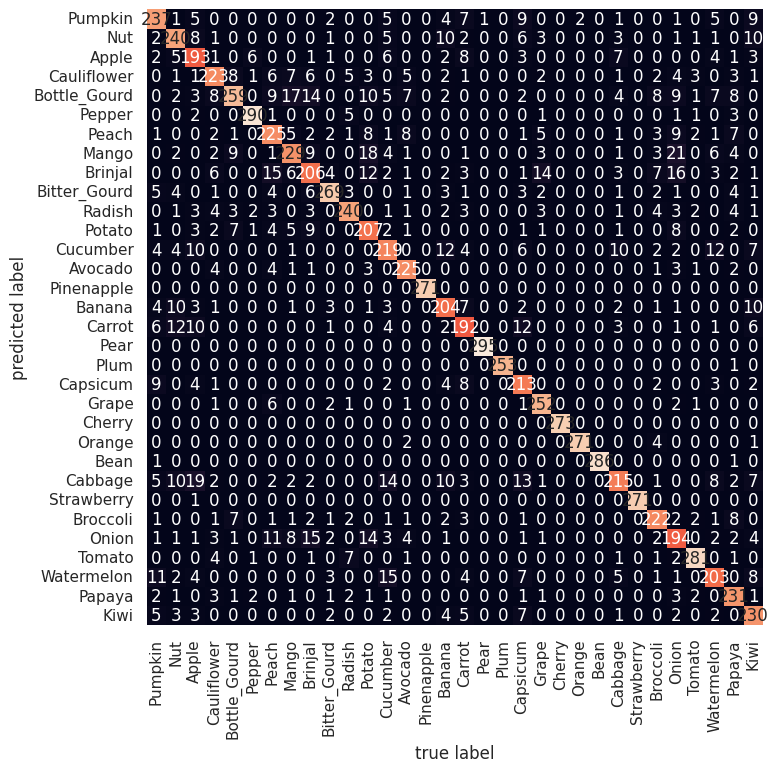

In [113]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

Попробуем избавить модель от переобучения с помощью PCA

In [161]:
svc = SVC(C=5, kernel='rbf')
pca = PCA(n_components=0.6)
svc_model = make_pipeline(pca, svc)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

In [162]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.7865792410714286

In [163]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.74      0.57      0.64       297
     Avocado       0.72      0.63      0.67       299
      Banana       0.73      0.64      0.68       273
        Bean       0.57      0.53      0.55       270
Bitter_Gourd       0.46      0.77      0.57       296
Bottle_Gourd       0.83      0.89      0.86       303
     Brinjal       0.50      0.50      0.50       292
    Broccoli       0.49      0.69      0.57       284
     Cabbage       0.47      0.44      0.45       277
    Capsicum       0.59      0.72      0.65       294
      Carrot       0.76      0.78      0.77       266
 Cauliflower       0.78      0.62      0.69       277
      Cherry       0.67      0.57      0.62       295
    Cucumber       0.84      0.66      0.74       259
       Grape       0.99      1.00      0.99       271
        Kiwi       0.62      0.63      0.63       266
       Mango       0.63      0.60      0.62       252
         Nut       0.98    

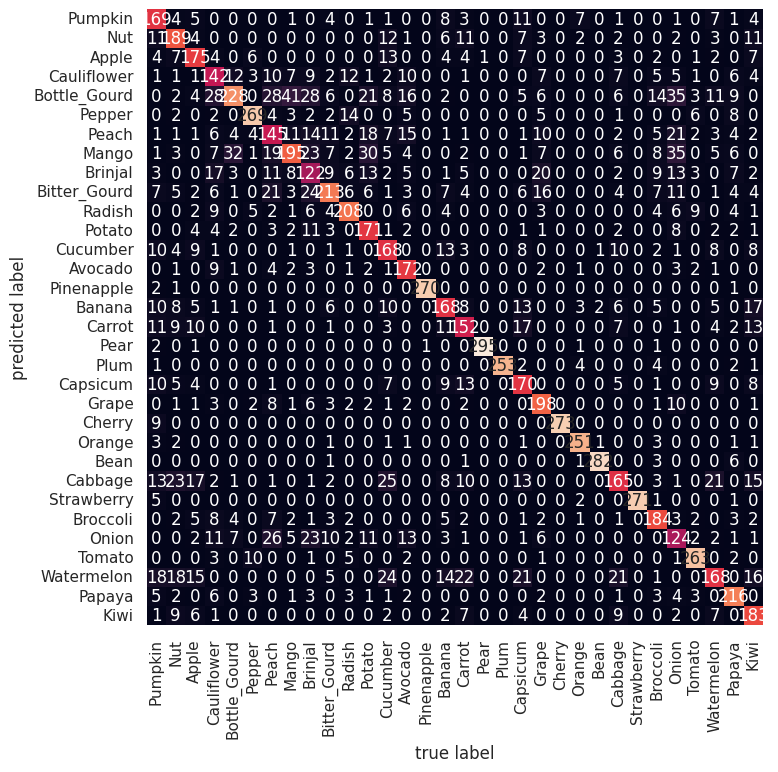

In [164]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

С помощью PCA удается уменьшить переобученность модели, но, судя по метрикам, это ухуджает ее качество

**SVM C=10, kernel='rbf' 64px на цветных изображениях orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)**


In [18]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/35840 [00:00<?, ?it/s]

  0%|          | 0/8960 [00:00<?, ?it/s]

In [22]:
svc = SVC(C=10, kernel='rbf')
pca = PCA(n_components=0.4)
svc_model = make_pipeline(pca, svc)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

In [23]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.8213169642857143

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.69      0.64      0.66       295
     Avocado       0.67      0.61      0.64       271
      Banana       0.74      0.64      0.68       302
        Bean       0.72      0.66      0.69       303
Bitter_Gourd       0.57      0.82      0.67       294
Bottle_Gourd       0.88      0.95      0.91       259
     Brinjal       0.52      0.54      0.53       296
    Broccoli       0.51      0.64      0.57       259
     Cabbage       0.57      0.58      0.57       296
    Capsicum       0.65      0.80      0.72       289
      Carrot       0.76      0.81      0.78       261
 Cauliflower       0.78      0.63      0.70       297
      Cherry       0.62      0.61      0.62       266
    Cucumber       0.85      0.79      0.82       266
       Grape       0.99      1.00      0.99       287
        Kiwi       0.63      0.61      0.62       270
       Mango       0.64      0.68      0.66       253
         Nut       0.99    

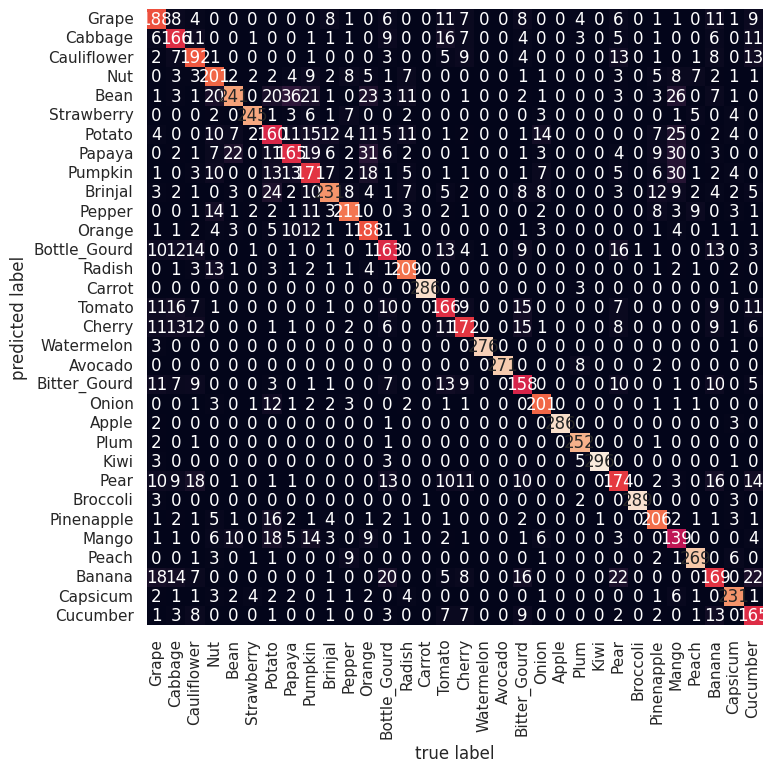

In [25]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [114]:
create_resized_dataset((128, 128), None)

  0%|          | 0/32 [00:00<?, ?it/s]

**SVM	C=10, kernel='rbf'	128px	на цветных изображениях	orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10)**

In [115]:
X_train_hog, X_test_hog, y_train, y_test = upload_colored_hog_features(orientations=3, pixels_per_cell=(12, 12), cells_per_block=(10, 10))

svc_model = SVC(C=10, kernel='rbf')
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

Загрузка изображений...


  0%|          | 0/32 [00:00<?, ?it/s]

Выделение HOG значений...


  0%|          | 0/35840 [00:00<?, ?it/s]

  0%|          | 0/8960 [00:00<?, ?it/s]

In [116]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.9999441964285715

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.84      0.81      0.83       297
     Avocado       0.82      0.81      0.81       299
      Banana       0.74      0.79      0.77       273
        Bean       0.84      0.90      0.87       270
Bitter_Gourd       0.91      0.92      0.92       296
Bottle_Gourd       0.96      0.96      0.96       303
     Brinjal       0.84      0.88      0.86       292
    Broccoli       0.89      0.91      0.90       284
     Cabbage       0.80      0.87      0.83       277
    Capsicum       0.89      0.93      0.91       294
      Carrot       0.90      0.92      0.91       266
 Cauliflower       0.91      0.81      0.86       277
      Cherry       0.85      0.76      0.80       295
    Cucumber       0.97      0.94      0.95       259
       Grape       1.00      1.00      1.00       271
        Kiwi       0.82      0.82      0.82       266
       Mango       0.75      0.75      0.75       252
         Nut       1.00    

Эта модель явно переобучена, стоит попробовать добавить PCA

In [133]:
svc = SVC(C=10, kernel='rbf')
pca = PCA(n_components=0.4)
svc_model = make_pipeline(pca, svc)
svc_model.fit(X_train_hog, y_train)
y_pred = svc_model.predict(X_test_hog)

In [134]:
y_pred_tr = svc_model.predict(X_train_hog)
accuracy_score(y_train, y_pred_tr)

0.6281529017857143

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.60      0.41      0.49       297
     Avocado       0.52      0.52      0.52       299
      Banana       0.66      0.47      0.55       273
        Bean       0.33      0.36      0.34       270
Bitter_Gourd       0.53      0.76      0.62       296
Bottle_Gourd       0.43      0.50      0.46       303
     Brinjal       0.44      0.40      0.42       292
    Broccoli       0.41      0.52      0.46       284
     Cabbage       0.35      0.21      0.27       277
    Capsicum       0.33      0.55      0.41       294
      Carrot       0.42      0.52      0.46       266
 Cauliflower       0.72      0.55      0.62       277
      Cherry       0.62      0.40      0.49       295
    Cucumber       0.64      0.57      0.61       259
       Grape       0.89      0.92      0.90       271
        Kiwi       0.63      0.55      0.59       266
       Mango       0.52      0.58      0.55       252
         Nut       0.92    

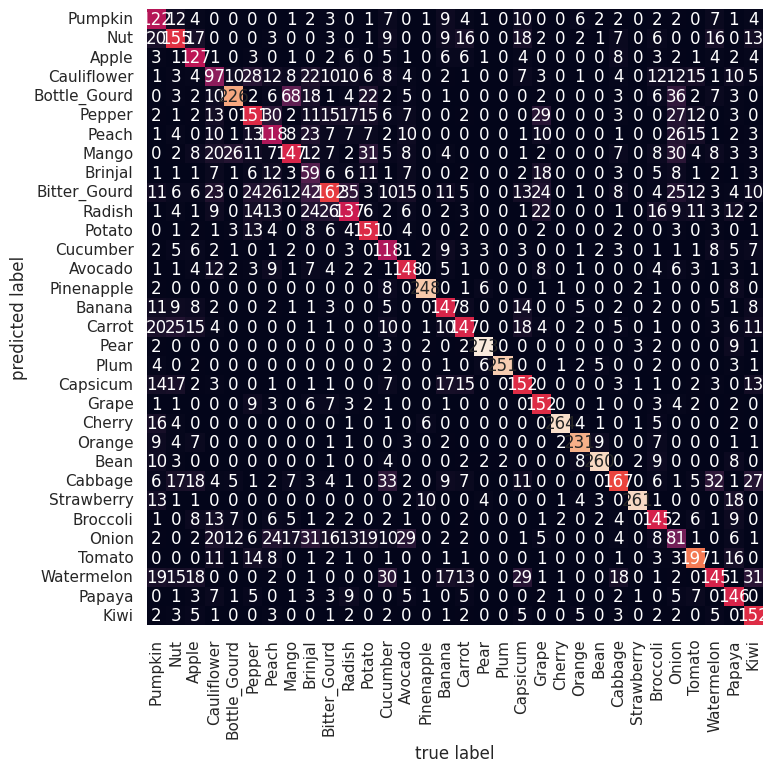

In [136]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

Уменьшив количество признаков удалось привести модель к непереобученному стостянию.